In [2]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

def generate_data_linear(
        n_patients, # number of samples
        n_features, # total number of features
        n_relevant, # number of features that related to outcomes
        n_events, # number of outcomes
        event_rates, # a list of event rates
        similarity, # similarity between target and secondary outcomes
        features_corr=0, # expected corr coef between features
        signal_strength=10, # scale parameter to control signal strength
        random_seed=2024, step_size=1e-3,
        print_output=True, plot=True, output_dir=None
):
    """
    Generate synthetic data using linear data generation process for multiple events.
    
    Steps:
    1. Set the random seed and Generate random features for the samples, possibly introducing correlation between features if specified.
    2. Generate coefficient vectors for the primary and secondary events.
        The similarity parameter controls how similar the secondary event coefficients are to the primary event coefficients.    3. Compute the hidden layer activations using ReLU (Rectified Linear Unit) for the target and secondary events. 
    4. For each event, calculate the logit (linear combination of features and coefficients) and determine an offset that achieves the desired event rate.
        Compute the probability of the event using the sigmoid function and generate event outcomes using a Bernoulli distribution.
    5. Save the generated features, probabilities, and events to files if an output directory is specified. 
        Print the mean event rates and plot the logits and probabilities if requested.
    
    Parameters:
    n_patients (int): Number of samples.
    n_features (int): Total number of features.
    n_relevant (int): Number of features that are related to outcomes.
    n_events (int): Number of outcomes.
    event_rates (list): List of event rates for each outcome.
    similarity (float): Similarity between target and secondary outcomes.
    features_corr (float): Expected correlation coefficient between features.
    signal_strength (float): Scale parameter to control signal strength.
    random_seed (int): Seed for random number generation.
    step_size (float): Step size for finding offset.
    print_output (bool): Whether to print output.
    plot (bool): Whether to plot the results.
    output_dir (str): Directory to save the output files.

    Returns:
    tuple: Features (x), probabilities (prob), and events (event).
    """
    
    # set random seed
    np.random.seed(random_seed)
    rs = np.random.RandomState(random_seed)

    # generate features
    x = np.random.normal(0, scale = signal_strength, size=(n_patients, n_features))
    if features_corr > 0:
        corr = np.full((n_features, n_features), features_corr) + np.eye(n_features)*(1-features_corr)
        x = x @ (np.linalg.cholesky(corr)).T

    # generate coefficient vectors for event 0 and secondary events
    u0 = normed_uniform(rs, n_features)
    u = u0
    for i in range(1, n_events):
        u = np.vstack((
            u,
            generate_vectors_by_similarity(u0, rs, similarity)
        ))

    logit = []
    prob = []
    event = []
    for i in range(n_events):
        # find logit offset that gives the desired event rate
        offset = find_offset(
            rs,
            np.dot(x[:,:n_relevant], u[i, :n_relevant]),
            event_rates[i],
            step_size,
        )
        # calculate event logit and probability, generate events
        l = np.dot(x[:,:n_relevant], u[i, :n_relevant]) - offset
        p = sigmoid(l)
        e = bernoulli_draw(rs, p)

        logit.append(l)
        prob.append(p)
        event.append(e)

    logit = np.array(logit).T
    prob = np.array(prob).T
    event = np.array(event).T

    # save data
    import os
    if output_dir is not None:
        plot_dir = os.path.join(output_dir, 'linear_similarity='+str(similarity)+'_signal='+str(signal_strength))

        # Check if my_dir exists, if not create it
        import os
        if not os.path.exists(plot_dir):
            os.makedirs(plot_dir)
                
        pickle.dump(x, open(plot_dir + '/x.pickle','wb'))
        pickle.dump(prob, open(plot_dir + '/prob.pickle','wb'))
        pickle.dump(event, open(plot_dir + '/event.pickle','wb'))
    
    if print_output:
        mean_event_rates = np.mean(event, axis=0)
        if output_dir is not None:        
            csv_file_path = os.path.join(plot_dir, 'event_rates.csv')

            # Save the mean event rates to the CSV file
            np.savetxt(csv_file_path, mean_event_rates, delimiter=',')
        
        print('Rate of events: ', mean_event_rates)

    if plot:
        fig = plot_logits_and_probs(logit, prob)
    
        if output_dir is not None:
            # Save the plot to my_dir with a specific filename
            plot_filename = os.path.join(plot_dir, 'simulation_logits_and_probs.png')
            fig.savefig(plot_filename)
            print(f"Plot saved to {plot_filename}")

    return x, prob, event


def generate_data_nonlinear(
        n_patients, # number of samples
        n_features, # total number of features
        n_relevant, # number of features that related to outcomes
        n_latent, # number of hidden features
        n_events, # number of outcomes
        event_rates, # a list of event rates
        similarity, # similarity between target and secondary outcomes
        features_corr=0, # expected corr coef between features
        signal_strength=10, # scale parameter to control signal strength
        random_seed=2024, step_size=1e-3,
        print_output=True, plot=True, output_dir=None
):
    """
    Generate synthetic data using nonlinear data generation process for multiple events. 
    
    Steps:
    1. Set the random seed and Generate random features for the samples, possibly introducing correlation between features if specified.
    2. Create a coefficient matrix defining latent features using random orthogonal sets and Glorot uniform initialization.
    3. Compute the hidden layer activations using ReLU (Rectified Linear Unit) for the target and secondary events. 
        The similarity parameter controls the overlap in latent features between target and secondary events. 
        E.g. If similarity between outcome 1 & 2 is 0.2, then these outcomes will share 1/5 hidden features.
    4. For each event, calculate the logit (linear combination of features and coefficients) and determine an offset that achieves the desired event rate.
        Compute the probability of the event using the sigmoid function and generate event outcomes using a Bernoulli distribution.
    5. Save the generated features, probabilities, and events to files if an output directory is specified. 
        Print the mean event rates and plot the logits and probabilities if requested.
    
    Parameters:
    n_patients (int): Number of samples.
    n_features (int): Total number of features.
    n_relevant (int): Number of features that are related to outcomes.
    n_latent (int): Number of hidden features.
    n_events (int): Number of outcomes.
    event_rates (list): List of event rates for each outcome.
    similarity (float): Similarity between target and secondary outcomes.
    features_corr (float): Expected correlation coefficient between features.
    signal_strength (float): Scale parameter to control signal strength.
    random_seed (int): Seed for random number generation.
    step_size (float): Step size for finding offset.
    print_output (bool): Whether to print output.
    plot (bool): Whether to plot the results.
    output_dir (str): Directory to save the output files.

    Returns:
    tuple: Features (x), probabilities (prob), and events (event).
    """
    # set random seed
    np.random.seed(random_seed)
    rs = np.random.RandomState(random_seed)

    # generate features
    x = np.random.normal(0, scale = signal_strength, size=(n_patients, n_features))
    if features_corr > 0:
        corr = np.full((n_features, n_features), features_corr) + np.eye(n_features)*(1-features_corr)
        x = x @ (np.linalg.cholesky(corr)).T

    # generate coefficient matrix defining latent features
    weights = random_orthogonal_set(n_latent*n_events, n_relevant, rs)
    weights = weights * (np.sqrt(6/(n_latent*n_events + n_relevant)))

    # generate coefficient vector for second layer
    coef = glorot_uniform(rs, n_latent*n_events, 1)
    
    hidden = []
    # target event
    W0 = np.concatenate(
        (weights[:n_latent,:].T,
        np.zeros(shape=(n_features-n_relevant, n_latent))),
        axis=0)
    hidden.append(relu(x @ W0))

    # secondary events
    n_overlap = round(n_latent*similarity)
    for i in range(1, n_events):
        W = np.concatenate(
            (weights[(n_latent*i):(n_latent*(i+1)),:].T,
            np.zeros(shape=(n_features-n_relevant, n_latent))),
            axis = 0)
        hidden.append(
            np.concatenate(
                [relu(x @ W0)[:, :n_overlap],
                relu(x @ W)[:, :(n_latent-n_overlap)]],
                axis = 1)
        )
    
    logit = []
    prob = []
    event = []
    for i in range(n_events):
        # find logi offset that gives the desired event rate
        c = np.concatenate((
            coef[:n_overlap],
            coef[(n_latent*i+n_overlap):(n_latent*(i+1))]
            ))
        offset = find_offset(
            rs,
            np.dot(hidden[i], c),
            event_rates[i],
            step_size,
        )
        # calculate event logit and probability, generate events
        l = np.dot(hidden[i], c) - offset
        p = sigmoid(l)
        e = bernoulli_draw(rs, p)

        logit.append(l)
        prob.append(p)
        event.append(e)

    logit = np.array(logit).T
    prob = np.array(prob).T
    event = np.array(event).T

    # save data
    import os
    if output_dir is not None:
        plot_dir = os.path.join(output_dir, 'nonlinear_similarity='+str(similarity)+'_signal='+str(signal_strength))

        # Check if my_dir exists, if not create it
        import os
        if not os.path.exists(plot_dir):
            os.makedirs(plot_dir)
                
        pickle.dump(x, open(plot_dir + '/x.pickle','wb'))
        pickle.dump(prob, open(plot_dir + '/prob.pickle','wb'))
        pickle.dump(event, open(plot_dir + '/event.pickle','wb'))
    
    if print_output:
        mean_event_rates = np.mean(event, axis=0)
        if output_dir is not None:        
            csv_file_path = os.path.join(plot_dir, 'event_rates.csv')

            # Save the mean event rates to the CSV file
            np.savetxt(csv_file_path, mean_event_rates, delimiter=',')
        
        print('Rate of events: ', mean_event_rates)

    if plot:
        fig = plot_logits_and_probs(logit, prob)
    
        if output_dir is not None:
            # Save the plot to my_dir with a specific filename
            plot_filename = os.path.join(plot_dir, 'simulation_logits_and_probs.png')
            fig.savefig(plot_filename)
            print(f"Plot saved to {plot_filename}")

    return x, prob, event


def random_orthogonal_set(n_vectors, dim, rs):
    # rank check
    if n_vectors>dim:
        raise ValueError("n_vectors > dim, cannot create orthogonal basis")

    vector_set = [normalize(rs.rand(dim))]

    for i in range(1, n_vectors):
        new_vector = rs.rand(dim)
        for j in range(i):
            projection = np.dot(new_vector, vector_set[j])*vector_set[j]
            new_vector -= projection
        vector_set.append(normalize(new_vector))

    return(np.array(vector_set))

def plot_logits_and_probs(logits, probs):
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))

    for i in range(logits.shape[1]):

        ax[0].hist(logits[:,i], alpha=.5, bins=20, label=f'Event {i}')
        ax[0].set_title('Event Logits')
        ax[0].legend()

        ax[1].hist(probs[:,i], alpha=.5, bins=20, label=f'Event {i}')
        ax[1].set_title('Event Probabilities')
        ax[1].legend()

    plt.show()
    
    return fig

def generate_vectors_by_similarity(u0, rs, s):

    # # generate vector 0
    # u0 = normed_uniform(rs, n)

    # generate a vector orthogonal to v0
    u0_ = normed_uniform(rs, u0.shape[0])
    u0_ = normalize(u0_ - u0 * np.dot(u0, u0_))

    # generate vector 1
    u = normalize(u0 * s + u0_ * (1 - s))

    return u


def find_offset(rs, logits, event_rate, step_size):

    offset = 0.
    rate = 1.

    while rate > event_rate:

        offset += step_size
        p = sigmoid(logits - offset)
        rate = np.mean(bernoulli_draw(rs, p))

    return offset


def normed_uniform(rs, n):
    return normalize(rs.normal(loc=0, scale=100, size=n))
    # return normalize(rs.rand(n) - .5)


def bernoulli_draw(rs, p):
    return (rs.rand(len(p)) < p).astype(int)


def glorot_uniform(rs, num_in, num_out):
    scale_factor = np.sqrt(6 / (num_in + num_out))
    return scale_factor * np.squeeze(rs.rand(num_in, num_out) - .5)
    # return np.random.normal(0, 1, size=(num_in, num_out))


def logit(p):
    return np.log(p / (1 - p))


def sigmoid(l):
    return 1 / (1 + np.exp(-1 * l))


def normalize(v):
    return (v / np.linalg.norm(v))


def relu(v):
    return np.maximum(v, 0)


Rate of events:  [0.02605556 0.01294444 0.06016667 0.03905556 0.16333333]


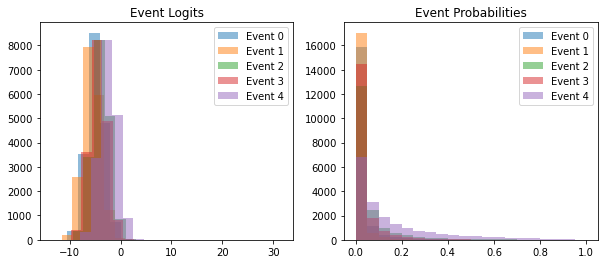

In [3]:
# Examples
# Note:
## The first event is designed to be target outcome.
## Similarity measures similarity between target outcome and secondary outcomes.
## Tune signal_strength to achieve your desired performance. 
## Larger signal_strength will make it easier to classify and give higher AUC.
## x is n_patients x n_features np-array (18000, 560)
## prob is n_patients x n_events np-array (18000, 5) range [0, 1]
## event is n_patients x n_events np-array (18000, 5) range {0, 1}

x, prob, event = generate_data_linear(
        n_patients=18000, # number of samples
        n_features=560, # total number of features
        n_relevant=400, # number of features that actually related to outcomes
        n_events=5, # number of outcomes
        event_rates=[0.022, 0.011, 0.057, 0.037, 0.157], # a list of event rates
        similarity=0.8, # similarity between target and secondary outcomes
        features_corr=0, # expected correlation between features
        signal_strength=2, # scale parameter to control signal strength
        random_seed=2024, step_size=1e-3,
        print_output=True, plot=True
)

Rate of events:  [0.02433333 0.01311111 0.06061111 0.0405     0.16311111]


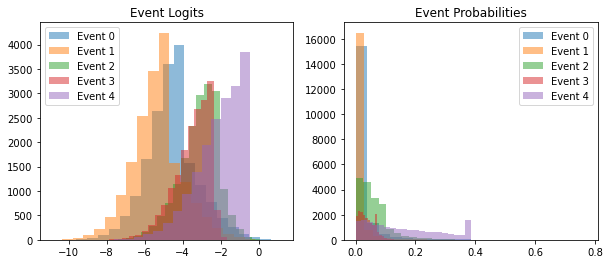

In [4]:
# Examples
# Note:
## The first event is designed to be target outcome.
## Similarity measures similarity between target outcome and secondary outcomes.
## For shared DGP, ensure that (n_latent*n_event < n_relevant) to guarantee the orthogonal set.
## x is n_patients x n_features np-array (18000, 560)
## prob is n_patients x n_events np-array (18000, 5) range [0, 1]
## event is n_patients x n_events np-array (18000, 5) range {0, 1}

x, prob, event = generate_data_nonlinear(
        n_patients=18000, # number of samples
        n_features=560, # total number of features
        n_relevant=400, # number of features that actually related to outcomes
        n_latent=5, # number of hidden features
        n_events=5, # number of outcomes
        event_rates=[0.022, 0.011, 0.057, 0.037, 0.157], # a list of event rates
        similarity=0.8, # similarity between target and secondary outcomes
        features_corr=0, # expected correlation between features
        signal_strength=60, # scale parameter to control signal strength
        random_seed=2024, step_size=1e-3,
        print_output=True, plot=True
)